In [1]:
import calendar

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

# Loading the data

In [2]:
temperature_df = pd.read_csv('Temperature Data.csv')
print('# rows:', len(temperature_df))
temperature_df.head()

# rows: 89219


,name,country_name,country_code,continent,station_code,location_date,temp_mean_c,temp_min_c,temp_max_c
0,Atlanta,UnitedStates,USA,North America,KATL,4/20/2021,17.491667,12.2,23.3
1,Windsor Locks,UnitedStates,USA,North America,KBDL,4/20/2021,13.887500,3.9,22.2
2,Nashville,UnitedStates,USA,North America,KBNA,4/20/2021,15.175000,6.7,23.3
3,Boise,UnitedStates,USA,North America,KBOI,4/20/2021,9.329167,1.7,15.6
4,Boston,UnitedStates,USA,North America,KBOS,4/20/2021,16.716667,10.0,23.9


In [3]:
population_df = pd.read_csv('Population Data.csv')
print('# rows:', len(population_df))
population_df.head()

# rows: 285


,City,State,population,Lon,Lat
0,Henderson,Nevada,260068,-115.0375,36.0122
1,Manchester,New Hampshire,109830,-71.4439,42.9847
2,Elizabeth,New Jersey,125660,-74.1935,40.6663
3,Newark,New Jersey,277540,-74.1726,40.7242
4,Paterson,New Jersey,146427,-74.1628,40.9147


# Data inspection/cleaning

## Dealing with duplicate cities

In [4]:
duplicated_cities_df = population_df[population_df.City.duplicated(keep=False)]
duplicated_cities_df.sort_values('City')

,City,State,population,Lon,Lat
133,Aurora,Colorado,332354,-97.1247,32.7007
147,Aurora,Illinois,199672,-88.2901,41.7635
41,Columbia,South Carolina,130591,-80.8966,34.0298
189,Columbia,Missouri,110438,-92.3261,38.9479
25,Columbus,Ohio,797434,-82.9850,39.9848
136,Columbus,Georgia,194107,-84.8749,32.5102
207,Glendale,Arizona,230482,-112.1899,33.5331
250,Glendale,California,193111,-118.2458,34.1814
161,Kansas City,Kansas,146453,-94.7418,39.1225
186,Kansas City,Missouri,463202,-94.5511,39.1252


In [5]:
set(temperature_df.name).intersection(duplicated_cities_df.City)

{'Columbus', 'Richmond'}

In [6]:
population_df = population_df.drop(136) # Dropping "Columbus, Georgia". KCMH is in Ohio.
population_df = population_df.drop(219) # Dropping "Richmond, California". KRIC is in Virginia.

## Dealing with cities in temperature data that are not found in population data

In [7]:
populations = dict(zip(population_df.City, population_df.population))
stations_df = temperature_df[['station_code', 'name']].drop_duplicates().set_index('station_code')
set(stations_df.name).difference(populations)

{'Albany',
 "Chicago O'Hare",
 'Covington',
 'Detroit/Wayne',
 'NYC/LaGuardia',
 'Phoenix/Sky HRBR',
 'Raleigh/Durham',
 'Sacramento/Execu',
 'St Louis/Lambert',
 'Wash DC/Dulles',
 'Windsor Locks'}

In [8]:
# https://en.wikipedia.org/wiki/Albany,_New_York
population_df = population_df.append({'City': 'Albany', 'population': 98000}, ignore_index=True)

# https://en.wikipedia.org/wiki/Covington,_Kentucky
population_df = population_df.append({'City': 'Covington', 'population': 41000}, ignore_index=True)

# https://en.wikipedia.org/wiki/Research_Triangle
population_df = population_df.append({'City': 'Raleigh/Durham', 'population': 2080000}, ignore_index=True)

# https://en.wikipedia.org/wiki/Windsor_Locks,_Connecticut
population_df = population_df.append({'City': 'Windsor Locks', 'population': 12000}, ignore_index=True)

In [9]:
stations_df.name = stations_df.name.replace({"Chicago O'Hare": 'Chicago',
                                             'Detroit/Wayne': 'Detroit',
                                             'NYC/LaGuardia': 'New York',
                                             'Phoenix/Sky HRBR': 'Phoenix',
                                             'Sacramento/Execu': 'Sacramento',
                                             'St Louis/Lambert': 'St. Louis',
                                             'Wash DC/Dulles': 'Washington'})

In [10]:
populations = dict(zip(population_df.City, population_df.population))
assert all(stations_df.name.isin(populations))
stations_df['population'] = stations_df.name.replace(populations)
stations_df.head()

,name,population
station_code,,
KATL,Atlanta,432427
KBDL,Windsor Locks,12000
KBNA,Nashville,609644
KBOI,Boise,210145
KBOS,Boston,625087


## Inspection of temperature data

In [11]:
# No missing values in the dataframe (missing dates simply don't have rows)

temperature_df.isnull().sum()

name             0
country_name     0
country_code     0
continent        0
station_code     0
location_date    0
temp_mean_c      0
temp_min_c       0
temp_max_c       0
dtype: int64

In [12]:
# Everything is from United States

temperature_df.country_name.value_counts(dropna=False)

UnitedStates    89219
Name: country_name, dtype: int64

In [13]:
# Number of readings per station

assert all(temperature_df.groupby('station_code').name.nunique(dropna=False) == 1)
temperature_df.station_code.value_counts(dropna=False)

KPHX    2302
KMEM    2288
KBDL    2288
KSAC    2288
KBNA    2288
KSTL    2288
KBOI    2288
KSEA    2288
KPWM    2288
KLIT    2288
KBOS    2288
KLGA    2288
KPIT    2288
KLAS    2288
KRDU    2288
KRIC    2288
KPHL    2288
KORD    2288
KATL    2287
KSLC    2287
KPDX    2287
KCMH    2287
KALB    2287
KDCA    2287
KMSP    2287
KFAT    2287
KCVG    2287
KCQT    2287
KIAD    2287
KSFO    2287
KGEG    2287
KBUR    2287
KIAH    2287
KDTW    2286
KMSY    2286
KDFW    2286
KBUF    2286
KDEN    2286
KBWI    2286
Name: station_code, dtype: int64

In [14]:
# Portland has two stations.

(temperature_df[['name', 'station_code']]
 .drop_duplicates()
 .set_index('station_code')
 .sort_values('name'))

,name
station_code,
KALB,Albany
KATL,Atlanta
KBWI,Baltimore
KBOI,Boise
KBOS,Boston
KBUF,Buffalo
KBUR,Burbank
KORD,Chicago O'Hare
KCMH,Columbus


In [15]:
# Start and end dates per station

temperature_df.location_date = pd.to_datetime(temperature_df.location_date)
temperature_df.groupby('station_code').location_date.agg(['min', 'max'])

,min,max
station_code,,
KALB,2015-01-01,2021-04-19
KATL,2015-01-01,2021-04-20
KBDL,2015-01-01,2021-04-20
KBNA,2015-01-01,2021-04-20
KBOI,2015-01-01,2021-04-20
KBOS,2015-01-01,2021-04-20
KBUF,2015-01-01,2021-04-20
KBUR,2015-01-01,2021-04-20
KBWI,2015-01-01,2021-04-20


## Dealing with missing dates

In [16]:
temperature_df = temperature_df.set_index(['station_code', 'location_date']).sort_index()

stations = temperature_df.index.unique(level=0)

location_dates = temperature_df.index.unique(level=1)
date_index = pd.date_range(min(location_dates), max(location_dates))

new_index = pd.MultiIndex.from_product([stations, date_index], names=['station_code', 'location_date'])

is_filled = temperature_df.temp_mean_c.reindex(new_index).isnull()
temperatures = temperature_df.temp_mean_c.reindex(new_index, method='ffill')

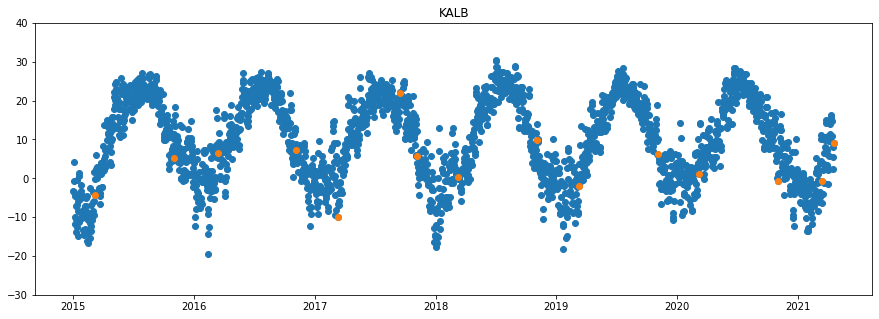

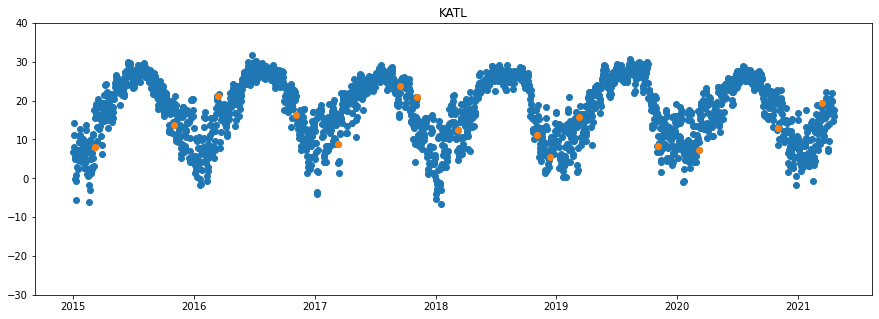

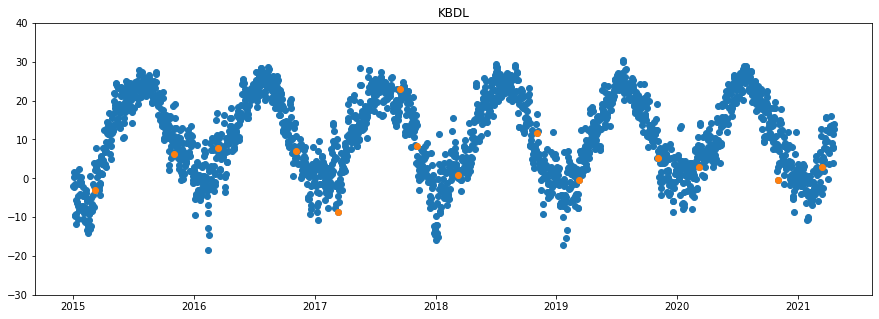

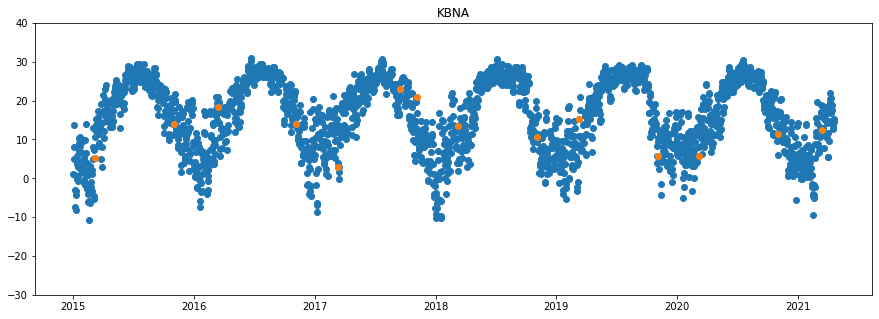

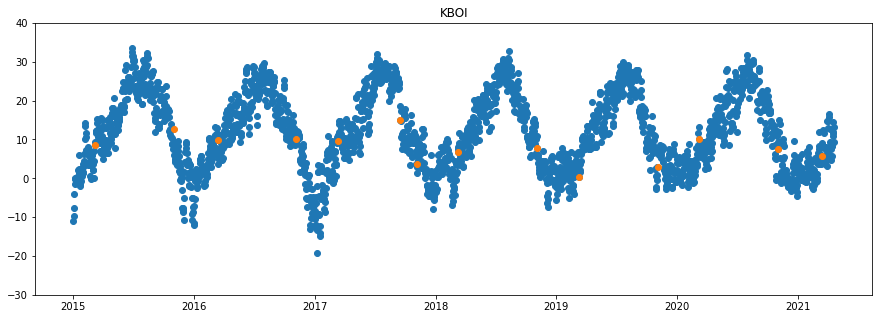

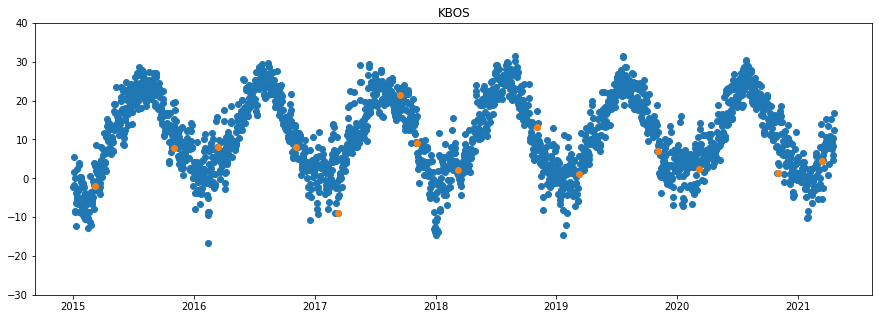

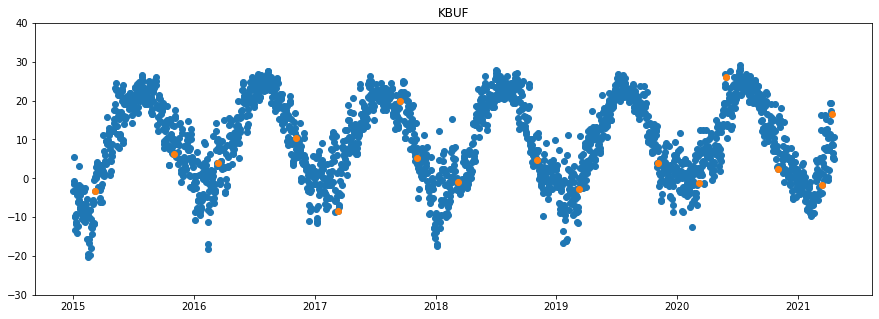

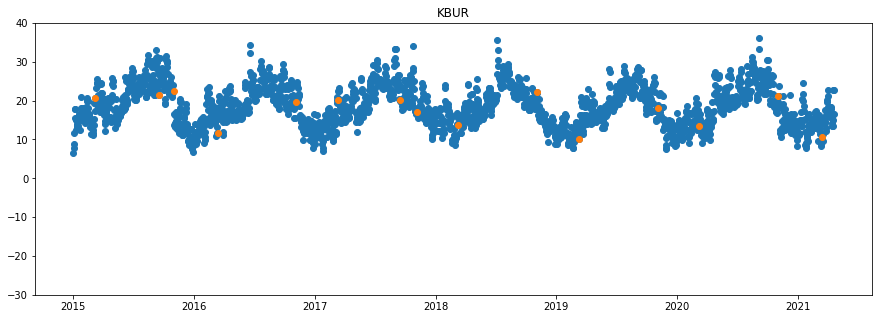

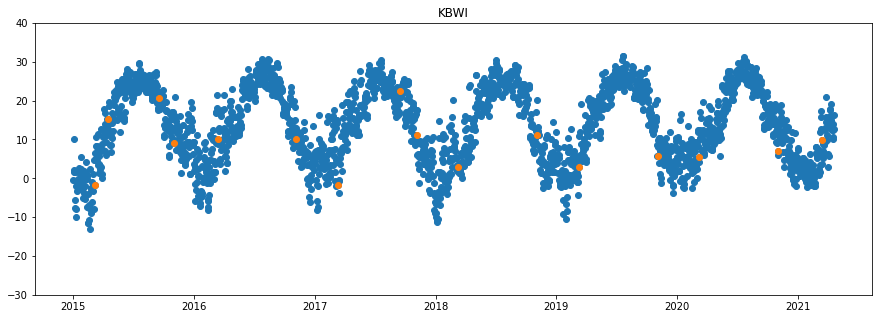

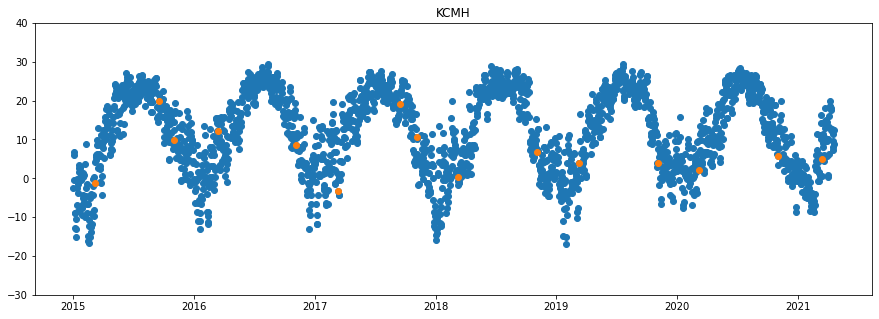

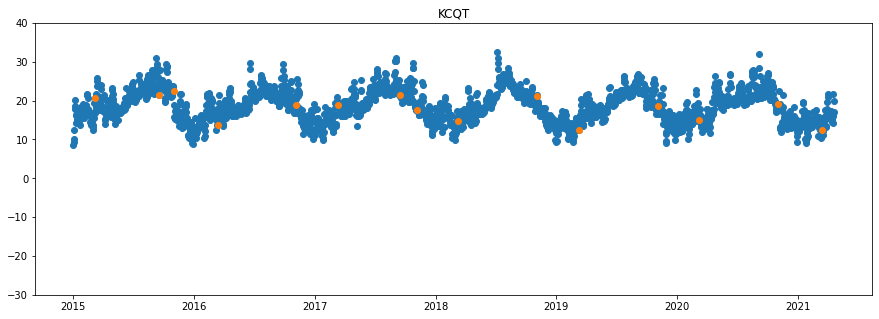

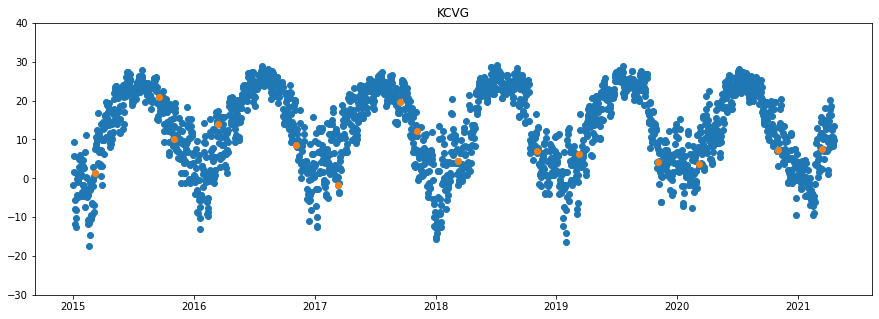

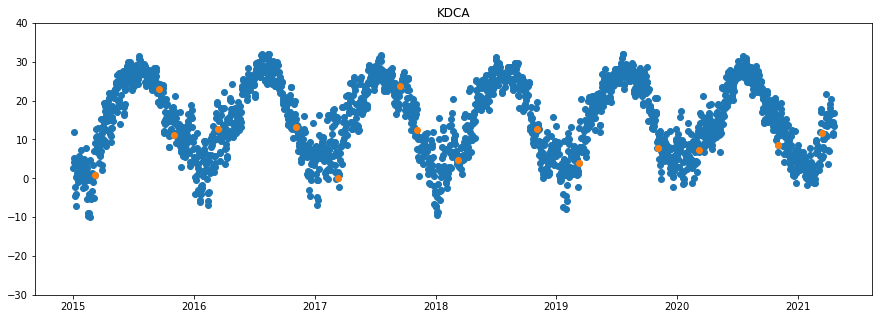

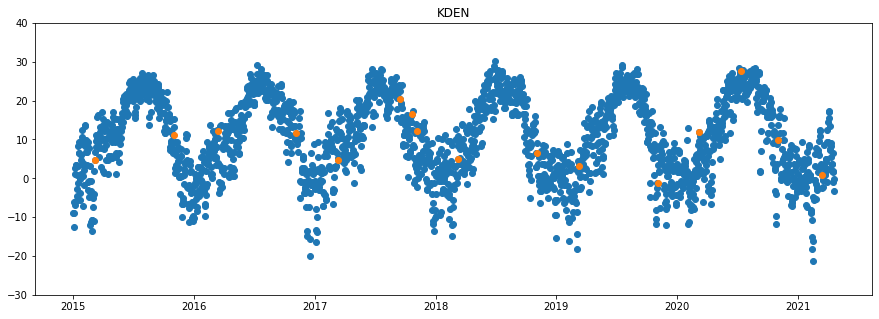

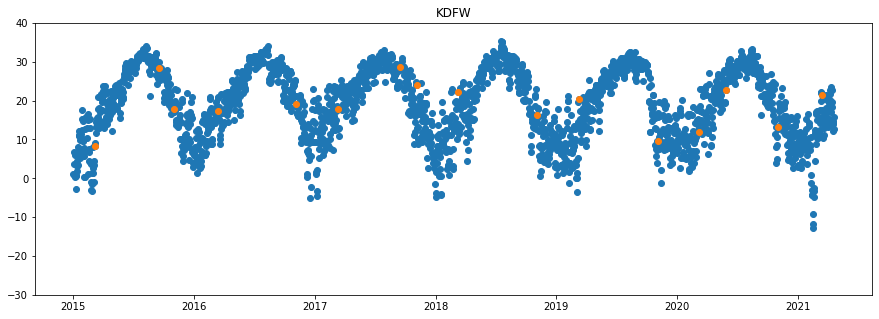

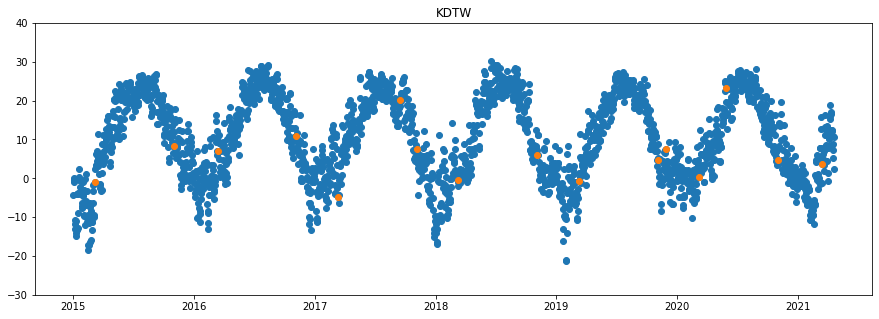

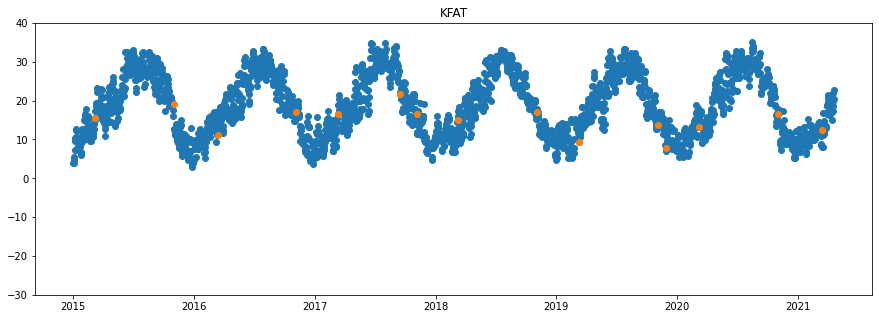

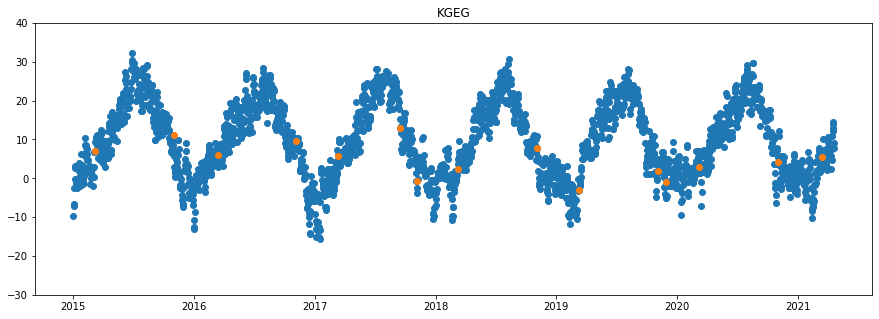

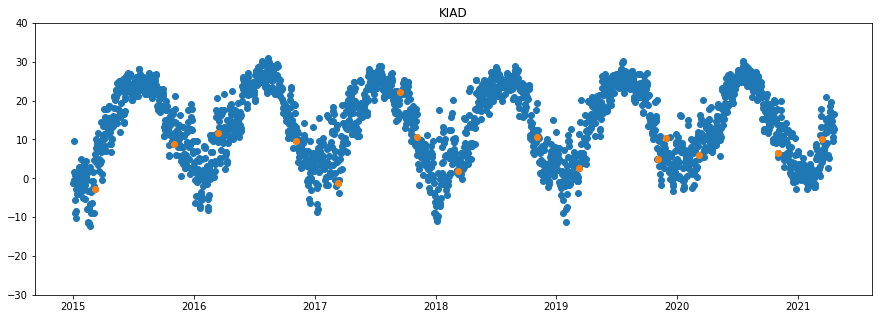

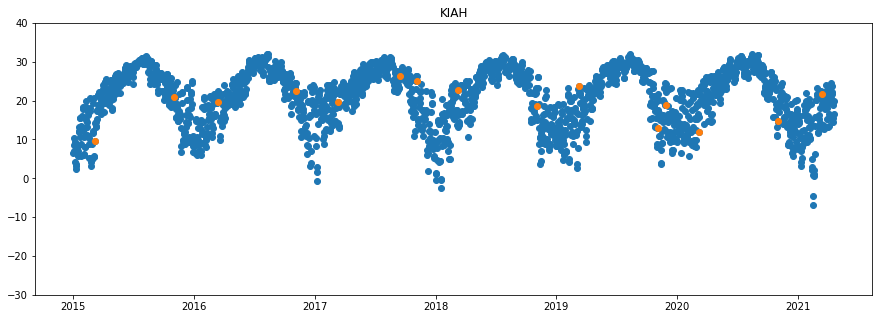

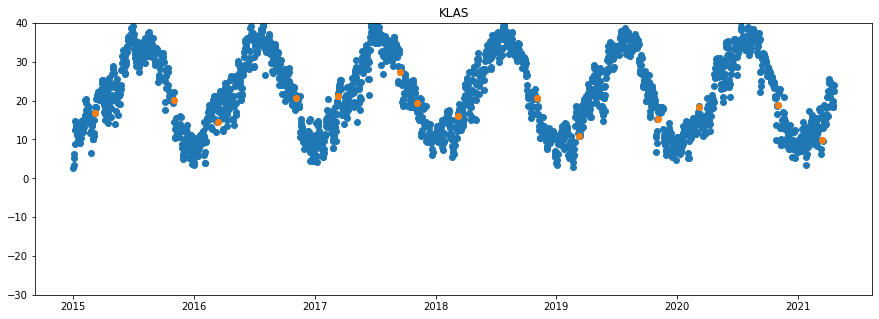

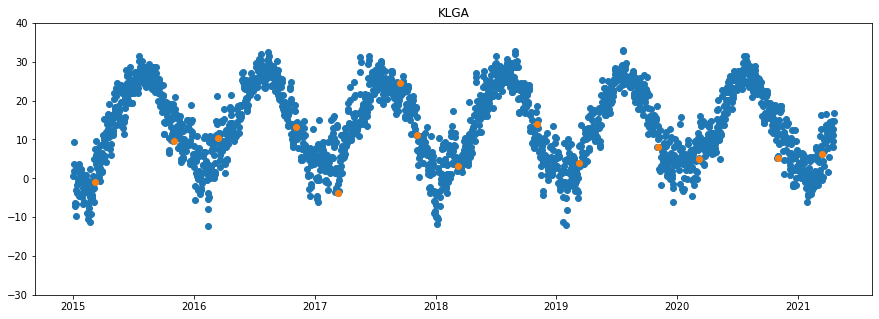

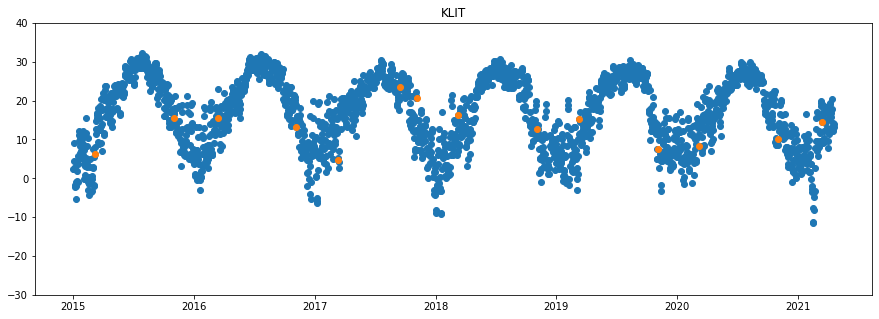

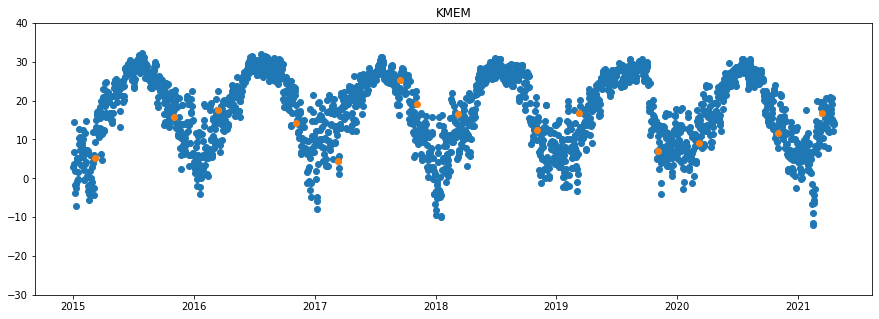

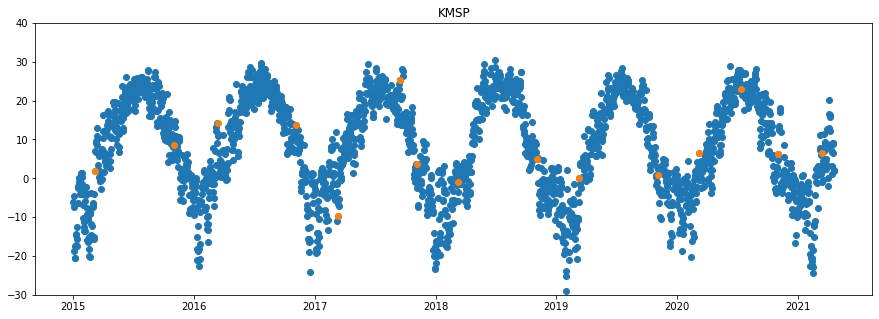

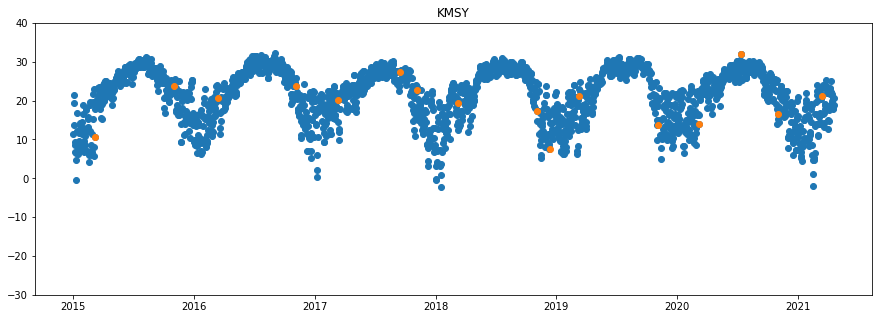

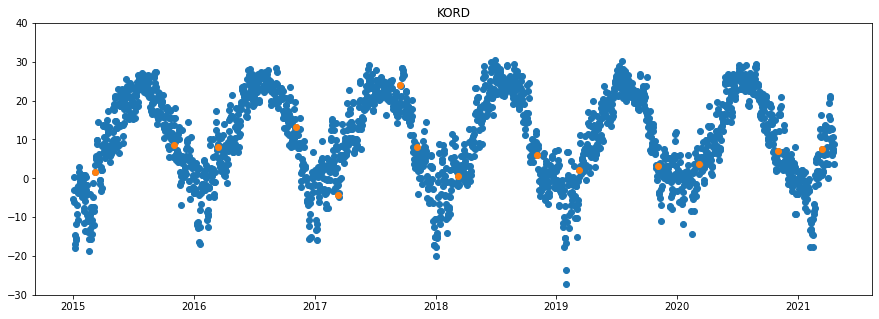

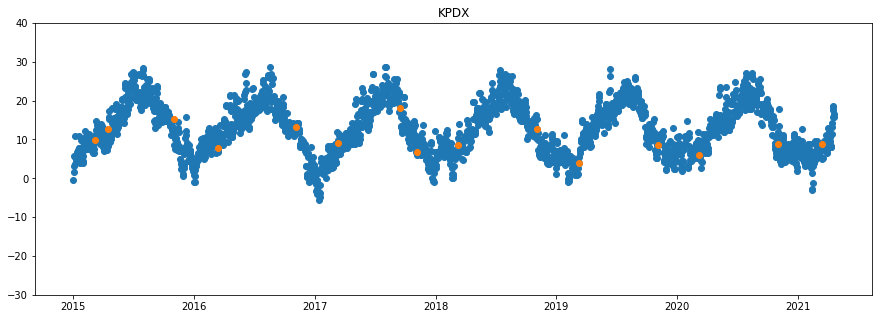

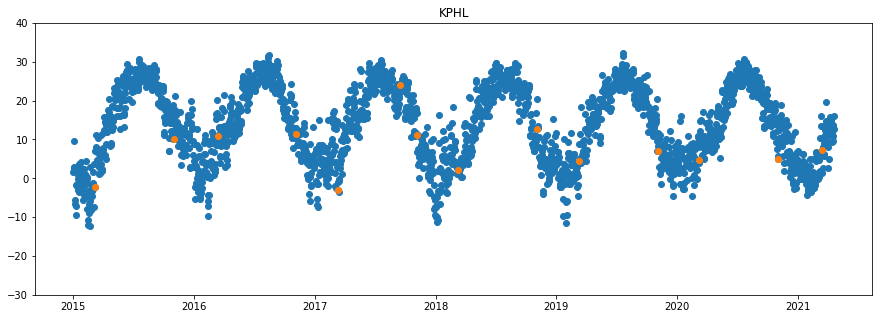

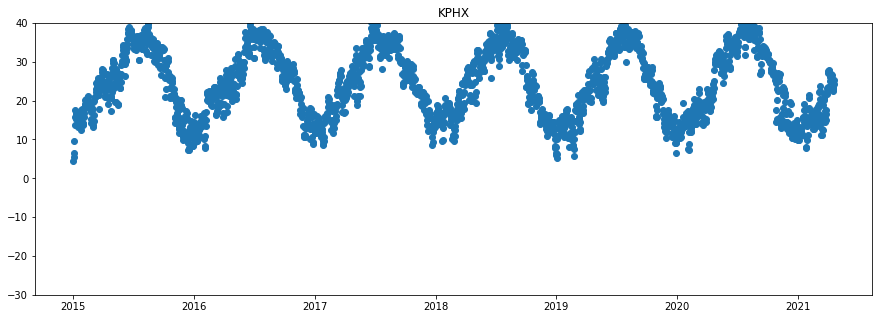

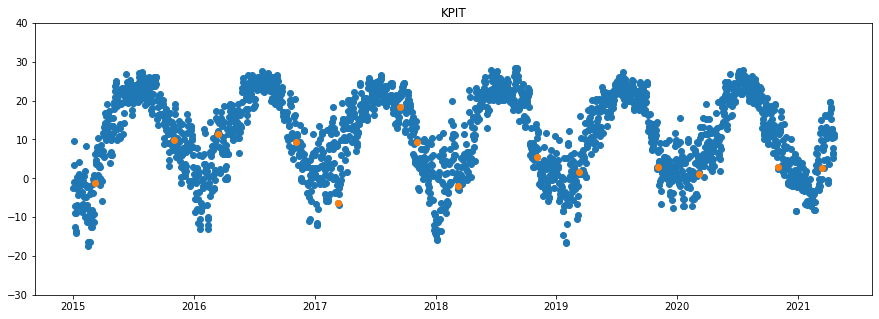

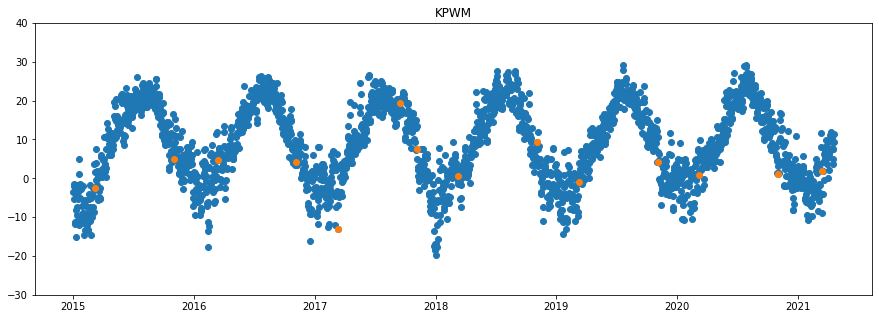

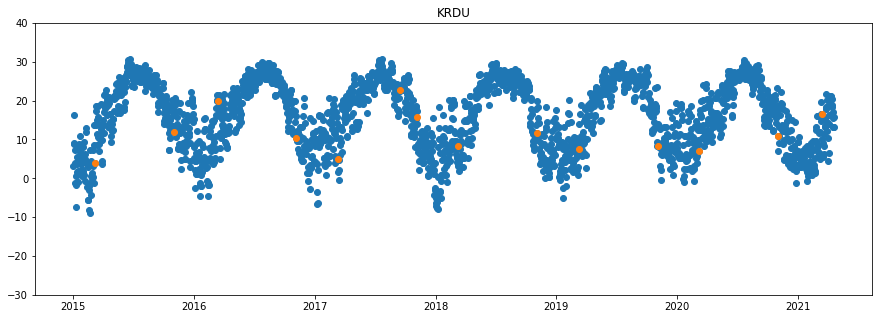

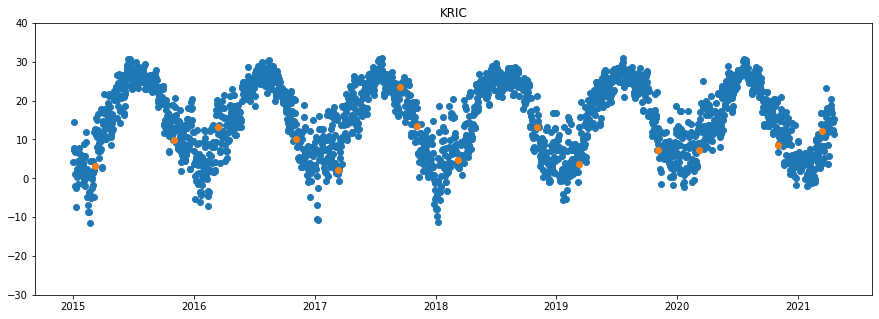

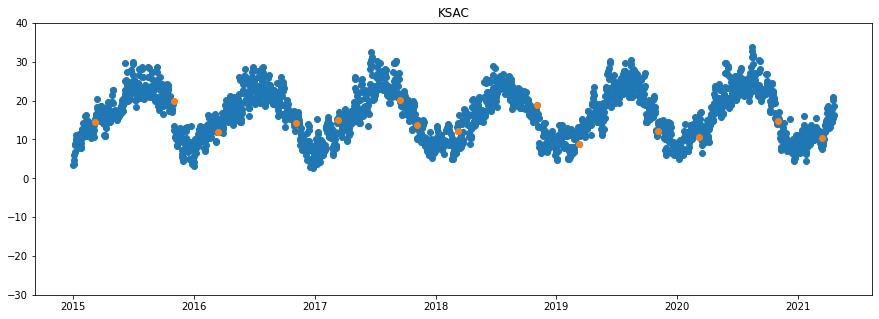

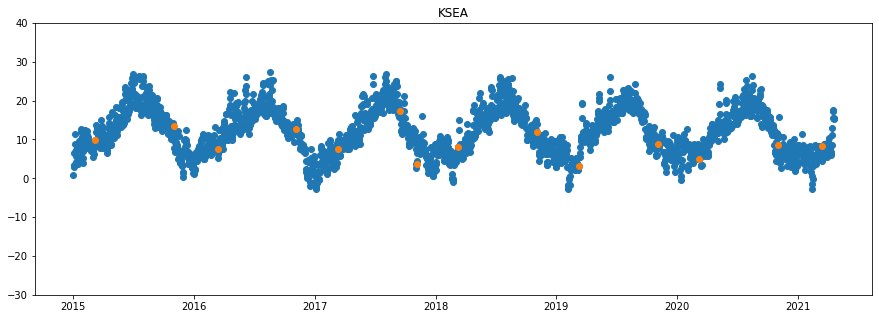

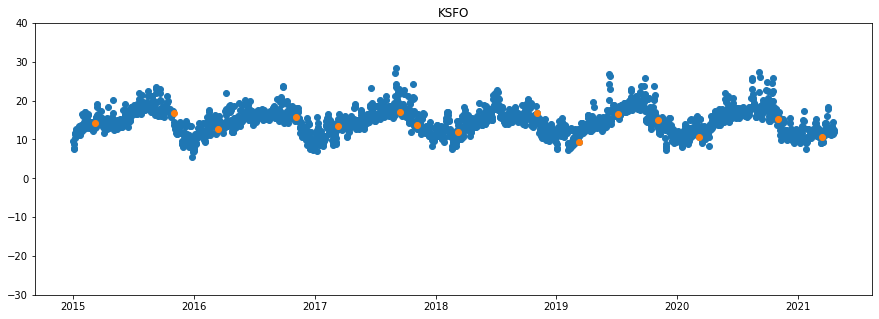

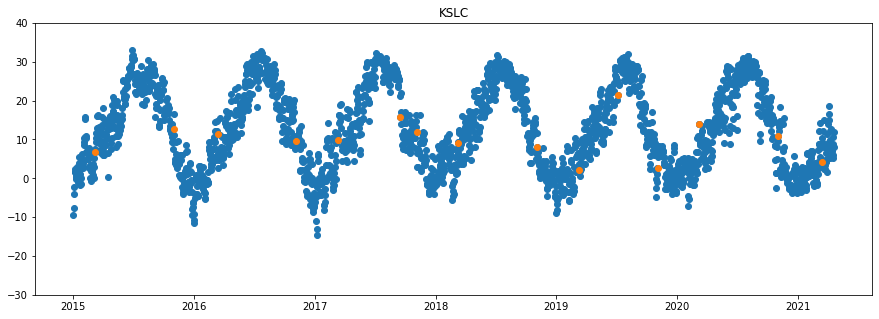

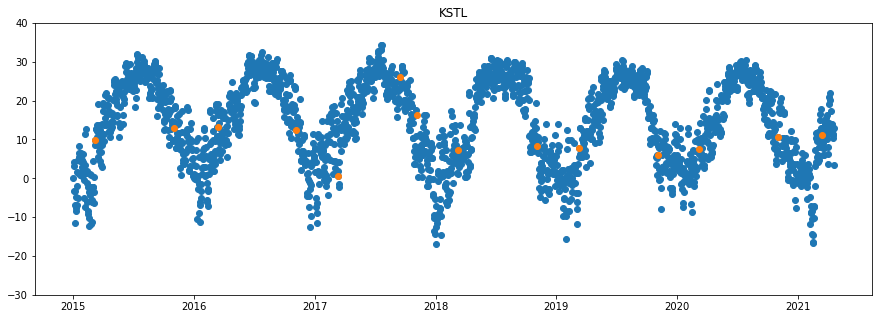

In [17]:
# Temperatures per station - missing/projected/inputted values in orange

for station in stations:
    this_temperatures = temperatures.loc[station]
    this_is_filled = is_filled.loc[station]    

    plt.figure(figsize=(15, 5))

    t = this_temperatures[~this_is_filled]
    plt.scatter(t.index, t)

    t = this_temperatures[this_is_filled]
    plt.scatter(t.index, t)

    plt.title(station)
    plt.ylim(-30, 40)

    plt.show()

# Weighted average temperatures

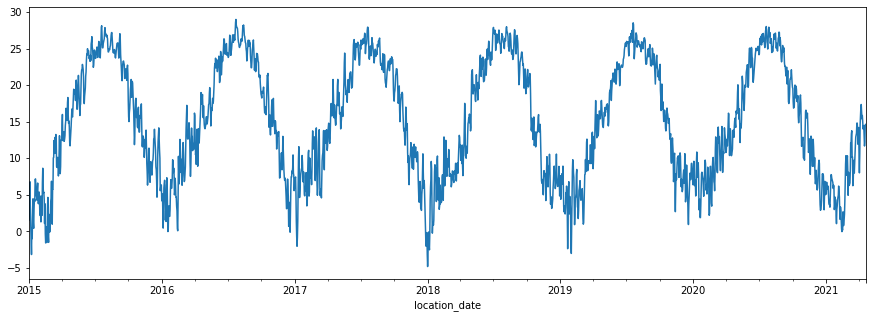

In [18]:
new_temperature_df = temperatures.reset_index().join(stations_df, on='station_code')

def weighted_average_temp(df):
    return np.average(df.temp_mean_c, weights=df.population)

average_temperature = new_temperature_df.groupby('location_date').apply(weighted_average_temp)
average_temperature

average_temperature.plot(figsize=(15, 5))
plt.show()

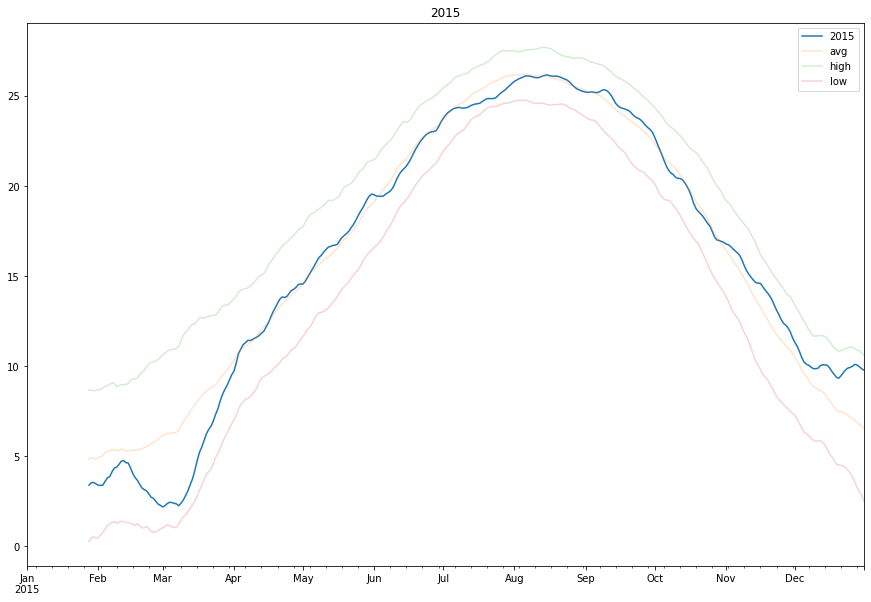

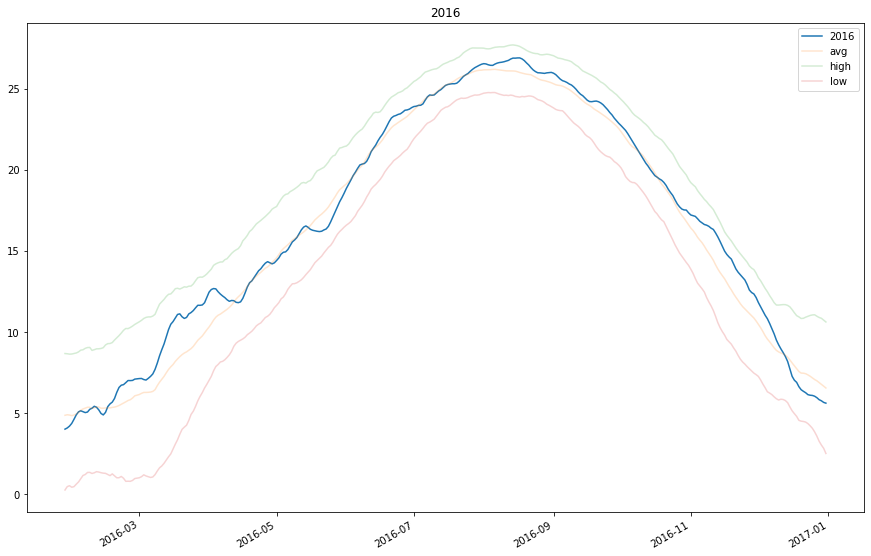

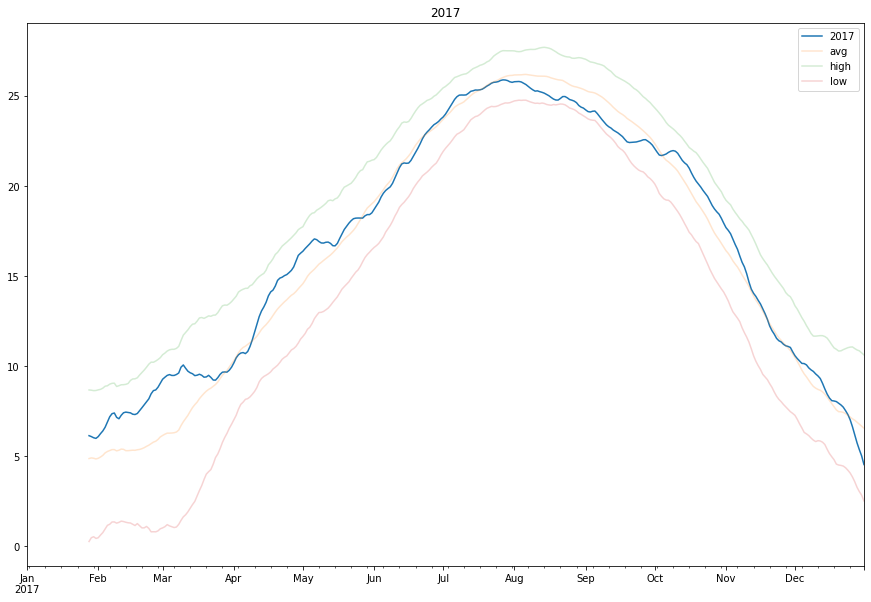

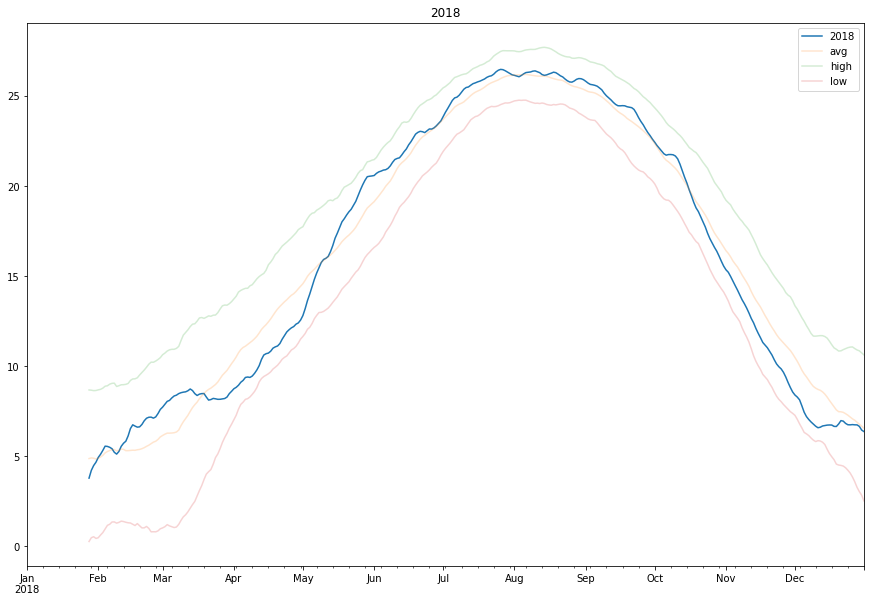

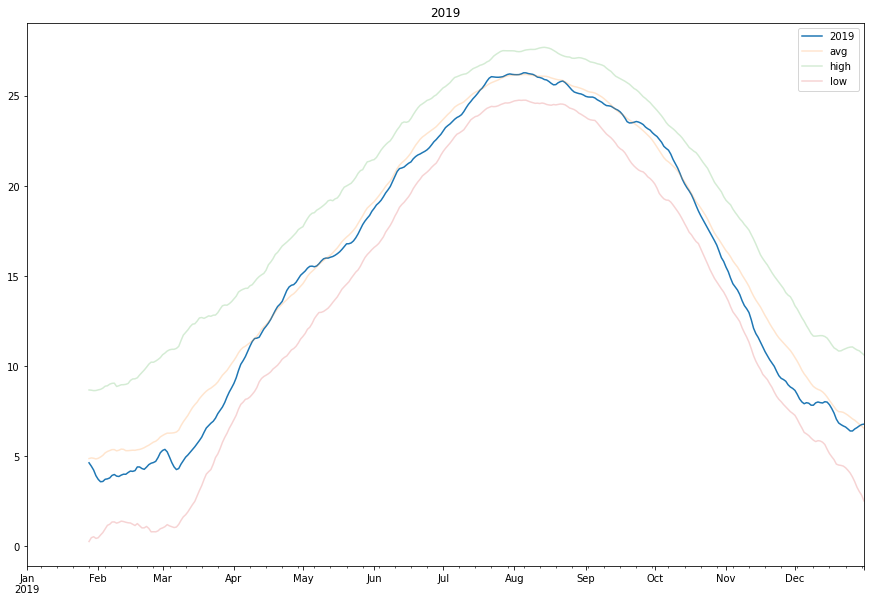

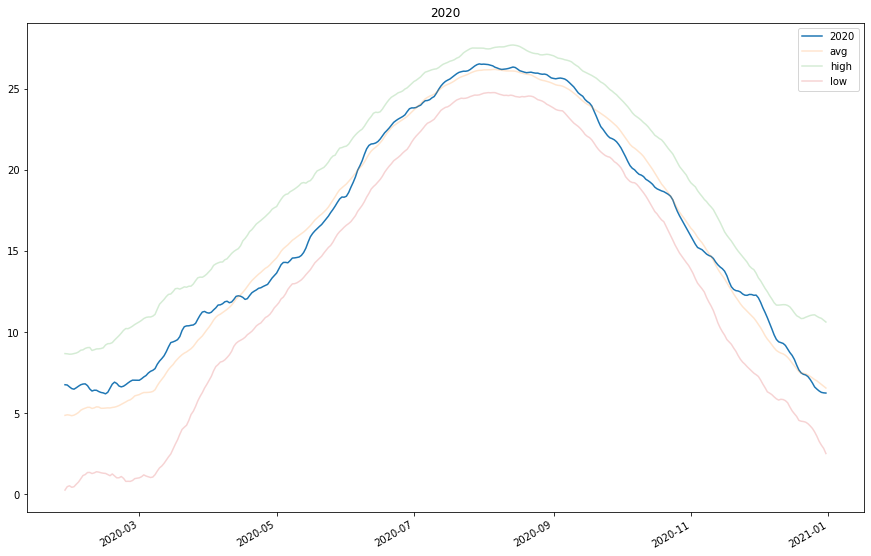

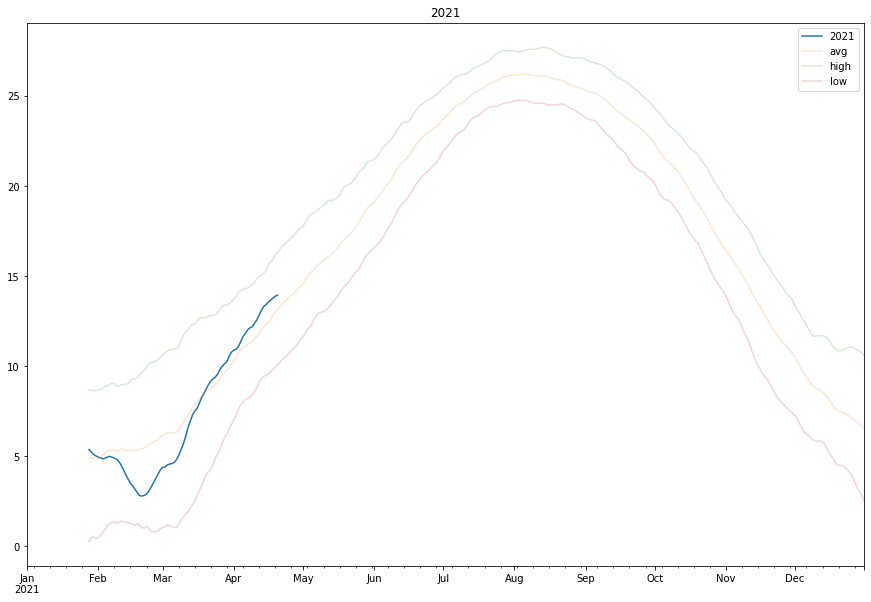

In [19]:
# Each year vs the "average" year (curves are smoothed using a rolling mean)


ROLLING_WINDOW = 28


grouped_by_year = average_temperature.groupby([average_temperature.index.month, average_temperature.index.day])

average_year = grouped_by_year.mean().drop((2, 29))
high_year = grouped_by_year.max().drop((2, 29))
low_year = grouped_by_year.min().drop((2, 29))

first_year = average_temperature.index.year[0]
last_year = average_temperature.index.year[-1]

per_year = []
averages = []

for year in range(first_year, last_year + 1):
    plt.figure(figsize=(15, 10))
    
    index = pd.date_range(f'{year}-01-01', f'{year}-12-31')
    
    this_year = pd.Series(average_temperature[average_temperature.index.year == year], index=index)
    if len(this_year) == 366:
        to_drop = pd.to_datetime(f'{year}-02-29')
        this_year = this_year.drop(to_drop)
        index = index.drop(to_drop)
    averages.append(this_year.mean())
    this_year = this_year.rolling(ROLLING_WINDOW).mean()
    per_year.append(this_year.reset_index(drop=True))

    this_average_year = pd.Series(average_year.reset_index(drop=True))
    this_average_year.index = index
    this_average_year = this_average_year.rolling(ROLLING_WINDOW).mean()

    this_high_year = pd.Series(high_year.reset_index(drop=True))
    this_high_year.index = index
    this_high_year = this_high_year.rolling(ROLLING_WINDOW).mean()

    this_low_year = pd.Series(low_year.reset_index(drop=True))
    this_low_year.index = index
    this_low_year = this_low_year.rolling(ROLLING_WINDOW).mean()

    this_year.plot(label=year)
    this_average_year.plot(label='avg', alpha=0.2)
    this_high_year.plot(label='high', alpha=0.2)
    this_low_year.plot(label='low', alpha=0.2)

    plt.title(year)
    plt.legend()

    plt.show()

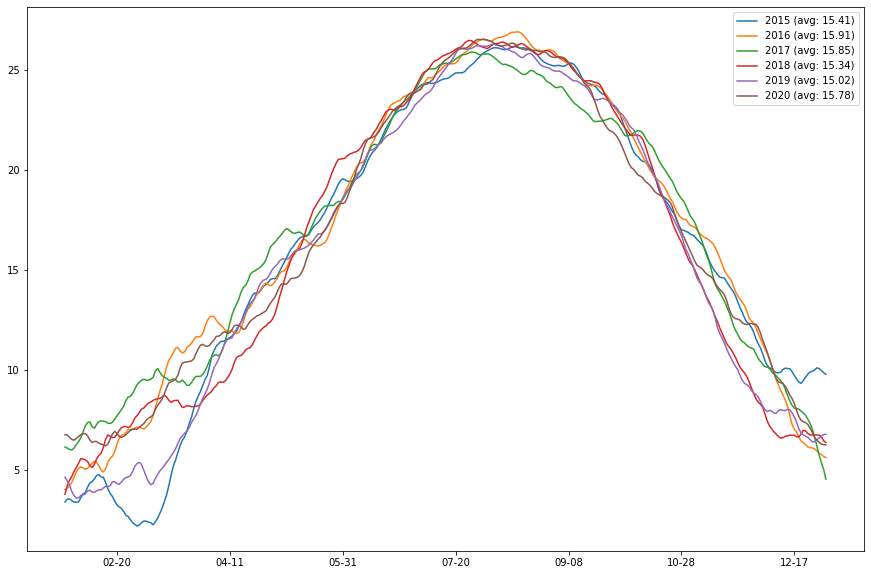

In [20]:
# Every years (curves are smoothed using a rolling mean)

index = pd.date_range('2021-01-01', '2021-12-31').strftime('%m-%d')

plt.figure(figsize=(15, 10))

for year, temperatures, average in zip(range(first_year, last_year), per_year[:-1], averages[:-1]):
    temperatures.index = index
    temperatures.plot(label=f'{year} (avg: {average:.2f})')

plt.legend()
plt.show()

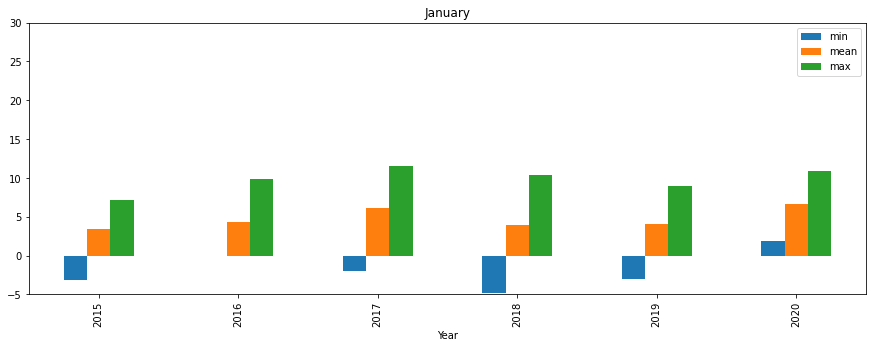

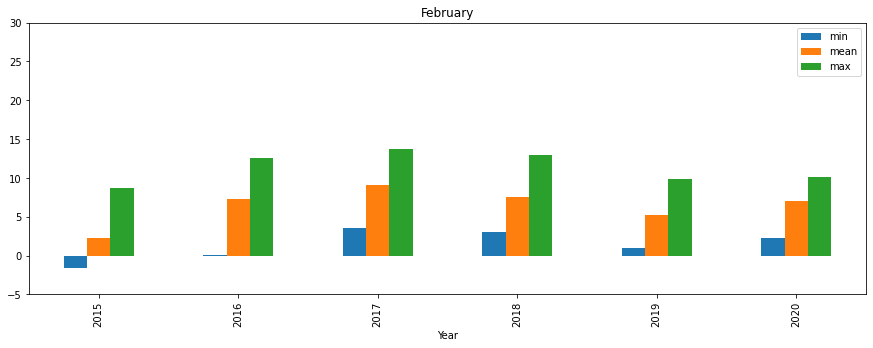

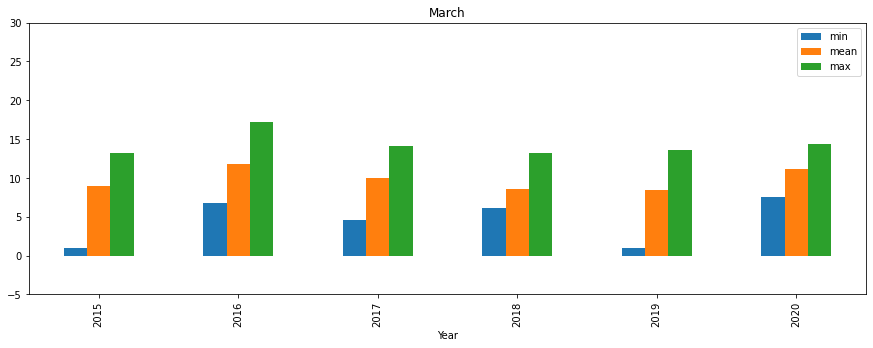

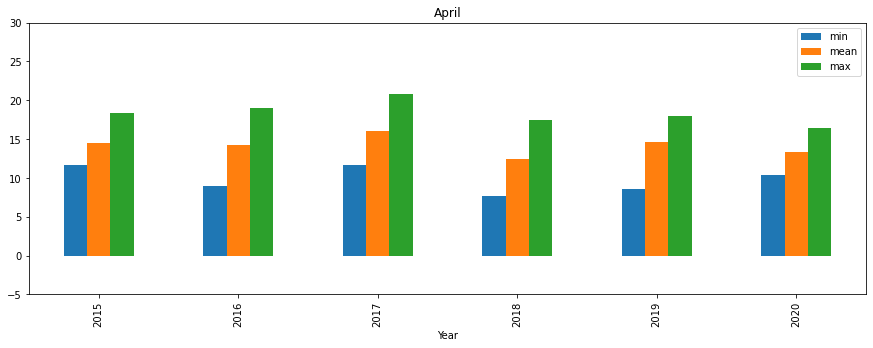

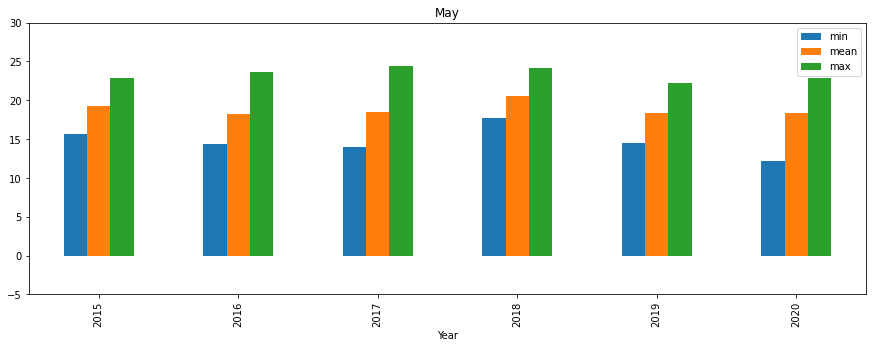

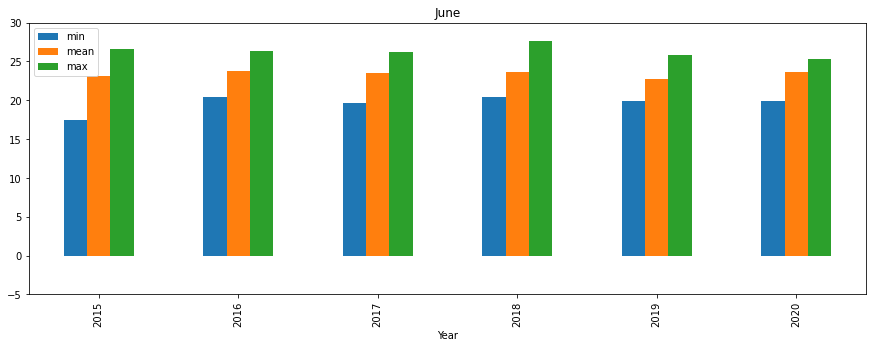

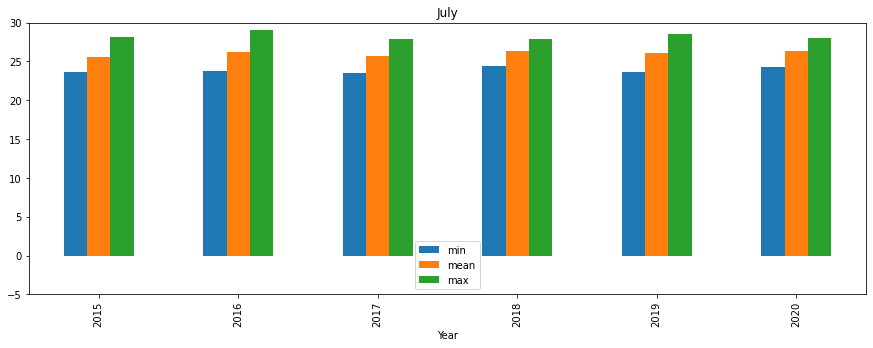

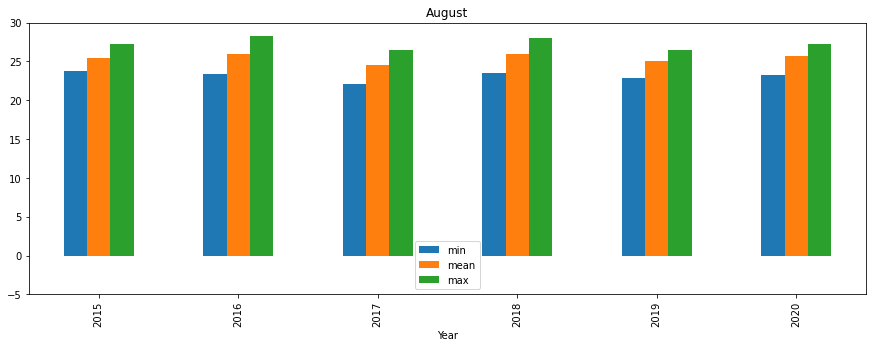

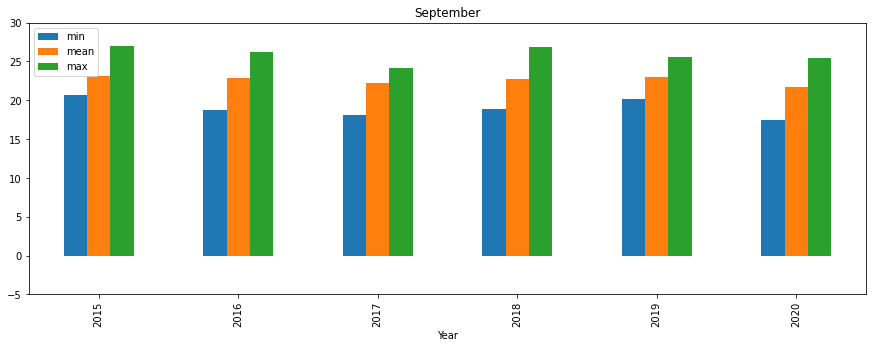

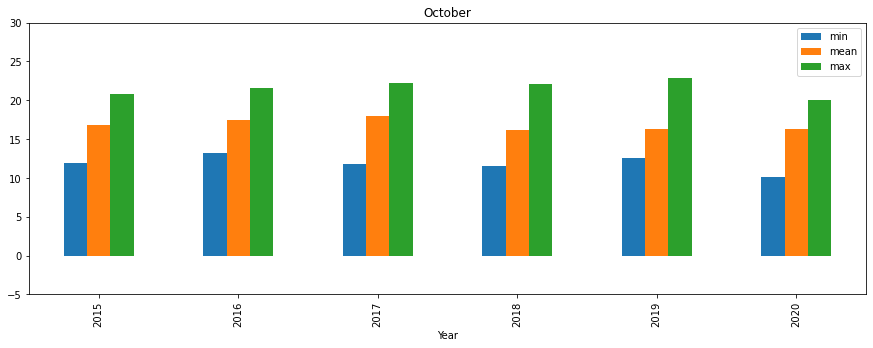

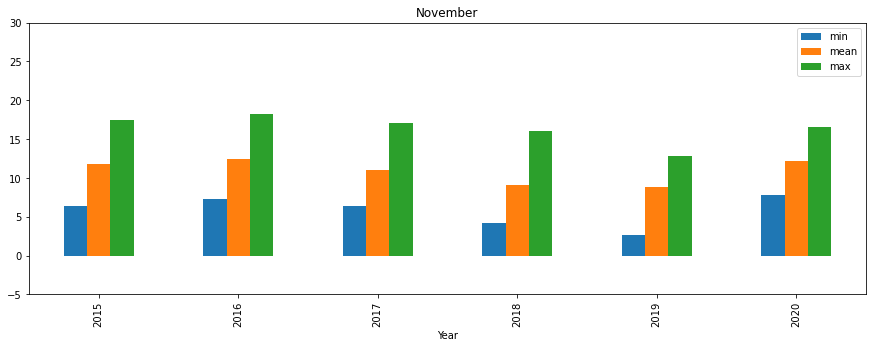

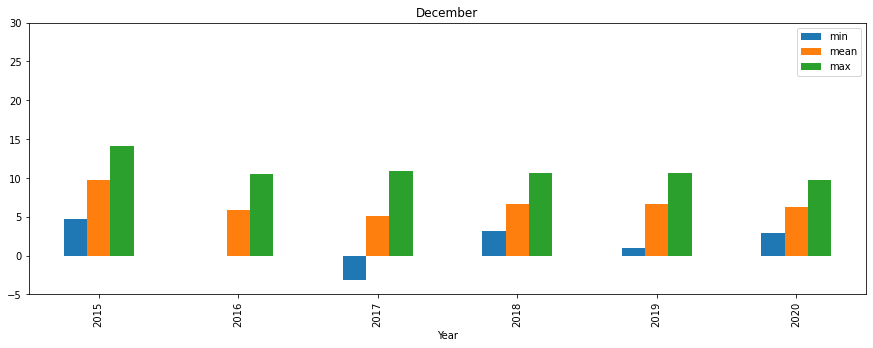

In [21]:
# Monthly temperatures

for month in range(1, 13):
    this_month = average_temperature[(average_temperature.index.month == month) &
                                     (average_temperature.index.year != 2021)]
   
    (this_month
     .groupby(this_month.index.year)
     .agg(['min', 'mean', 'max'])
     .plot(kind='bar', figsize=(15, 5)))

    plt.title(calendar.month_name[month])
    plt.xlabel('Year')
    plt.ylim(-5, 30)
    
    plt.show()